### The SWAP Test

The SWAP Test is a procedure commonly used to compare two states by applying CNOT gates to each qubit (for further information see [3]). By running the circuit $M$ times, and applying the SWAP test, we then measure the auxiliary qubit. We use the number of states in the state $|1\rangle$ to compute:

$$S = 1 - \frac{2}{M}L$$

where $L$ is the count for the states in the $|1\rangle$ state. As shown in [3], maximizing this function corresponds to the two states of which we are comparing being identical. We therefore aim to maximize this function, i.e. minimize  $\frac{2}{M}L$. This value will be therefore be our cost function.

In [1]:
import time
import warnings

import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output, HTML
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.quantum_info import Statevector
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

algorithm_globals.random_seed = 420

from autoenc import ansatz, auto_encoder_circuit

# RUN THIS CELL ONLY TO DOWNLOAD CIFAR

In [2]:
# Define transform to convert images to grayscale
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Download and load CIFAR10 dataset
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)

num_images = 8
subset = list(range(0, len(trainset), int(len(trainset)/num_images))) 
trainset = torch.utils.data.Subset(trainset, subset)
trainset = list(map(
    lambda x: (x[0].type(torch.float16).flatten().numpy(), x[1]), 
    trainset
))

print(f"We have {len(trainset)} samples of type {type(trainset[0][0])}")

trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,shuffle=True)

Files already downloaded and verified
We have 8 samples of type <class 'numpy.ndarray'>


We begin by defining our parametrized ansatz for the Quantum Autoencoder. This will be our parametrized circuit where we can tune the parameters to maximize the fidelity between the trash and reference states. 

### The Parametrized Circuit 

The parametrized circuit we will use below for our encoder is the RealAmplitude Ansatz available in Qiskit. One of the reasons why we have chosen this ansatz is because it is a 2-local circuit, the prepared quantum states will only have real amplitudes, and does not rely on full connectivity between each qubits, which is hard to implement or can lead to deep circuits. 

We define our parametrized circuit for our Encoder below, where we set the repetition parameter to `reps=5`, to increase the number of parameters in our circuit allowing greater flexibility. 

We define a function below to implement the above circuit configuration to the $5$ qubit domain wall state $|00111\rangle$ and plot an example below. Here qubits $5$ and $6$ are the reference state, $0, 1, 2, 3, 4$ are the initial state we wish to compress and qubit $7$ is our auxiliary qubit which is used in the swap test. We also include a classical register to measure the results of qubit $7$ in the swap test. 

## 7. A Quantum Autoencoder for Digital Compression

One can also apply a Quantum Autoencoder to more complicated examples, such as a set of handwritten digits in order to compress the dataset. Below, we will show that we can indeed train an Quantum Autoencoder to compress such an example, giving us the ability to store data more efficiently on a Quantum Computer. 

For this tutorial, we will build a Quantum Autoencoder for a noisy dataset containing zeros and ones, which can be seen below. 

Each image contains $32$ pixels of which can be encoded into $5$ qubits by Amplitude Encoding. This can be done using Qiskit's `RawFeatureVector` feature map.  

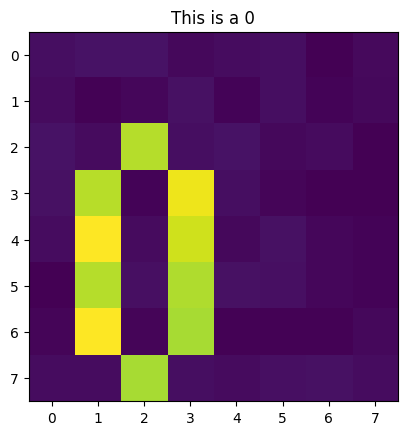

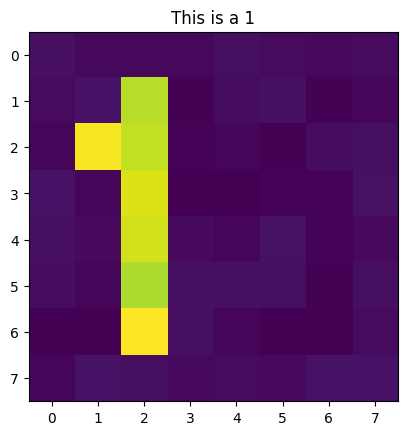

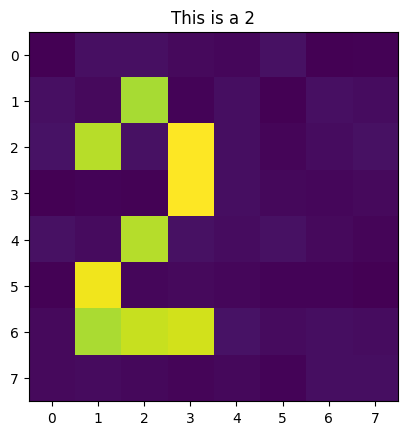

torch.Size([3, 64])


In [9]:
def zero_idx(i, j): # Index for zero pixels
    return [
        [i-1, j], [i-1, j - 1], [i-1, j - 2], [i-1, j - 3], 
        [i, j+1], [i, j - 4],
        [i+1, j], [i+1, j - 1], [i+1, j - 2], [i+1, j - 3],
    ]


def one_idx(i, j):
    # Index for one pixels
    return [[i, j - 1], [i, j - 2], [i, j - 3], [i, j - 4], [i, j - 5], [i - 1, j - 4], [i, j]]

def two_idx(i, j):
    # Index for one pixels
    return [[i-1, j - 1], [i, j - 2], [i+1, j - 3], [i+1, j - 4], [i, j - 5], [i - 1, j - 4], 
           [i, j], [i-1,j], [i+1,j]]

def get_dataset_digits(num, draw=True):
    # Create Dataset containing zero and one
    train_images = []
    train_labels = []
    
    func = [zero_idx, one_idx, two_idx]
    internal_dim = 64
    for number in range(3):
        for i in range(int(num / 2)):
            # First we introduce background noise
            empty = np.array(
                [algorithm_globals.random.uniform(0, 0.05) for i in range(internal_dim)]
            ).reshape(8, 8)

            # Now we insert the pixels for the one
            for i, j in func[number](2, 6):
                empty[j][i] = algorithm_globals.random.uniform(0.86, 1)
            train_images.append(empty)
            train_labels.append(number)
            if draw:
                plt.title(f"This is a {number}")
                plt.imshow(train_images[-1])
                plt.show()

    train_images = np.array(train_images)
    train_images = train_images.reshape(len(train_images), internal_dim)

    for i in range(len(train_images)):
        sum_sq = np.sum(train_images[i] ** 2)
        train_images[i] = train_images[i] / np.sqrt(sum_sq)

    return train_images, train_labels


train_images, __ = get_dataset_digits(2)
print(torch.tensor(train_images).shape)

In [3]:
def get_dataset_cifar(num, draw=True):
    # Create Dataset containing zero and one
    train_images = []
    train_labels = []

    trainset
    for tup in trainset:
        train_images.append(tup[0])
        train_labels.append(tup[1])
        
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    
    return train_images, train_labels

train_images, __ = get_dataset_cifar(2)
print(train_images.shape)

(8, 1024)


After encoding our image into $5$ qubits, we begin to train our Quantum Autoencoder to compress this state into $3$ qubits.

We repeat the steps in the previous example and write a cost function, again based on the Swap Test between the trash and latent space. We can also use the same Autoencoder function as given in the previous example, as the input state and trash space contain the same amount of qubits. 

Let's input one of our digits and see our circuit for the Autoencoder below. 

Using 1024 FeatureMap & 1010 AutoEncoder


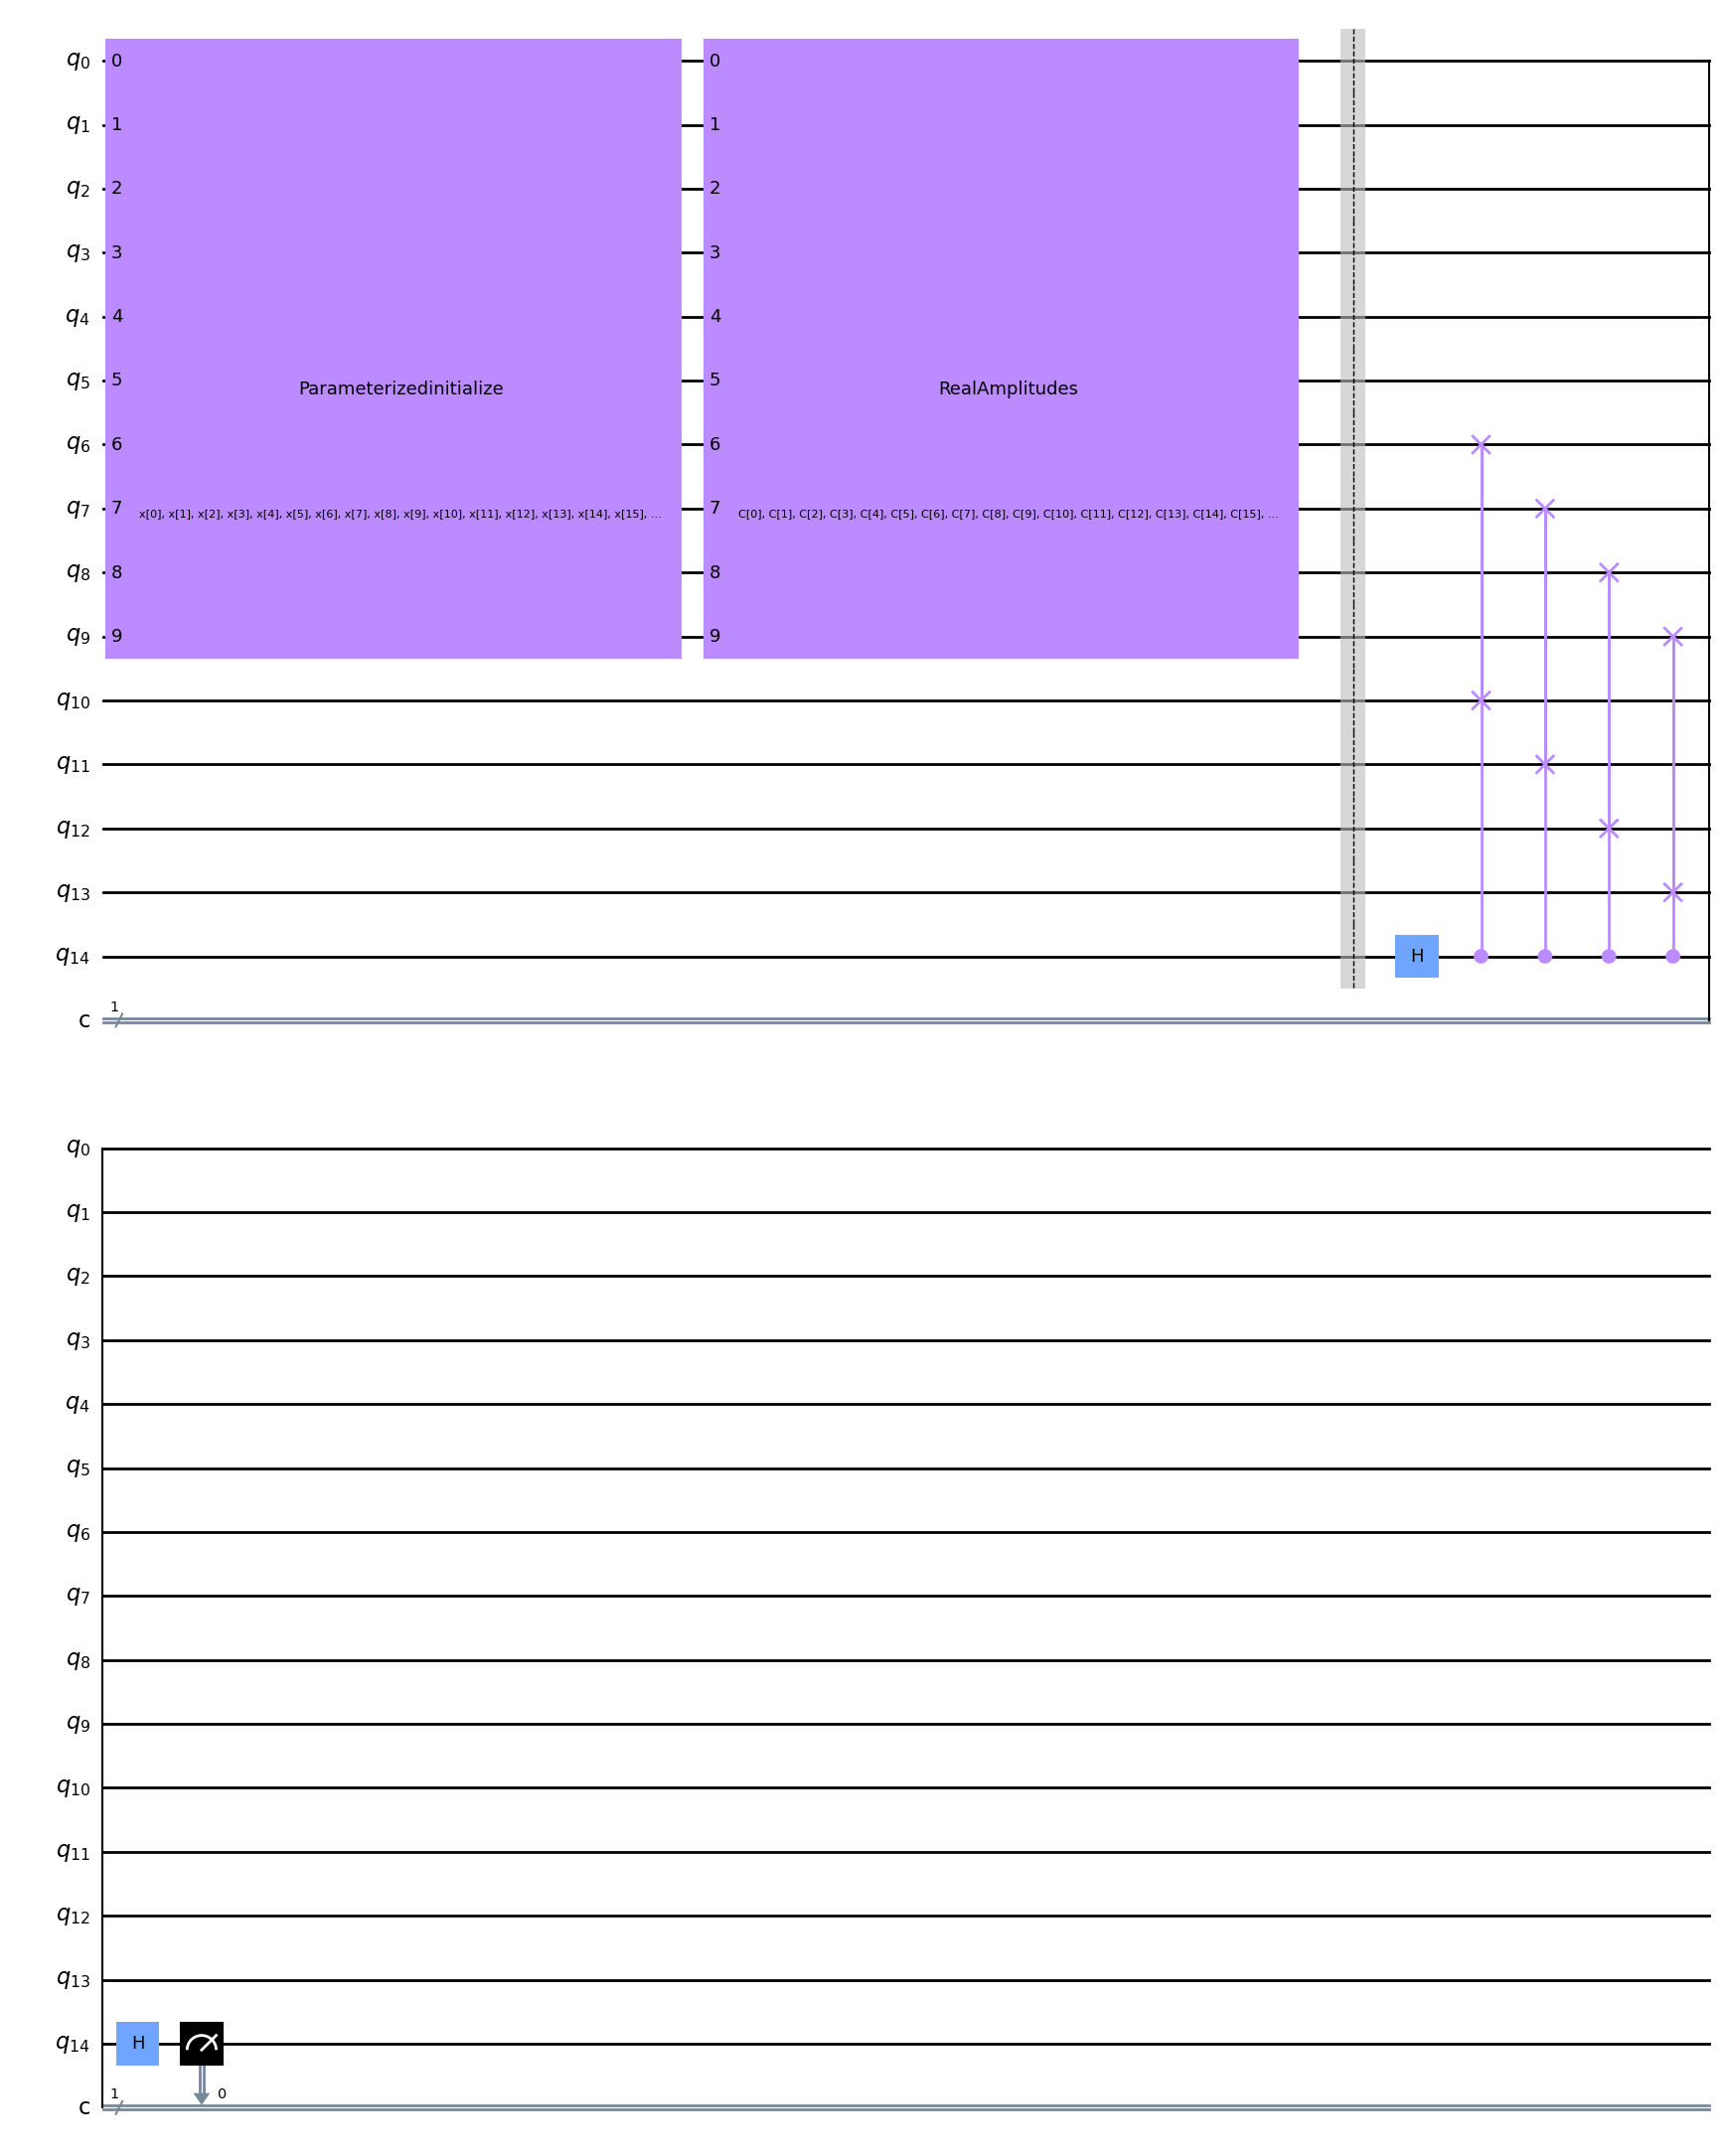

In [8]:
num_latent = 6
num_trash = 4

dimension = 2 ** (num_latent + num_trash)
fm = RawFeatureVector(dimension)

ae = auto_encoder_circuit(num_latent, num_trash)

# Latent + 2Trash + 1
qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(fm, range(num_latent + num_trash))
qc = qc.compose(ae)

print(f"Using {len(fm.parameters)} FeatureMap & {len(ae.parameters)} AutoEncoder")

qc.draw("mpl")

Again, we can see the swap test being performed on the qubits $3$, $4$, $5$ and $6$, which will determine the value of our cost function.

In [9]:
def identity(x):
    return x


qnn = SamplerQNN(
    circuit=qc,
    input_params=fm.parameters,
    weight_params=ae.parameters,
    interpret=identity,
    output_shape=2,
)

We build our cost function, based on the swap test between the reference and trash space for the digit dataset. To do this, we again use Qiskit's CircuitQNN network and use the same interpret function as we are measuring the probability of getting the final qubit in the $|1\rangle$ state.

In [10]:
def cost_func_digits(params_values):
    probabilities = qnn.forward(train_images, params_values)
    cost = np.sum(probabilities[:, 1]) / train_images.shape[0]

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    return cost

Since model training may take a long time we have already pre-trained the model for some iterations and saved the pre-trained weights. We'll continue training from that point by setting `initial_point` to a vector of pre-trained weights.

In [11]:
initial_point = [np.random.rand() for i in range(len(ae.parameters))]

By minimizing this cost function, we can thus determine the required parameters to compress our noisy images. Let's see if we can encode our images! 

In [ ]:
opt = COBYLA(maxiter=600)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(fun=cost_func_digits, x0=initial_point)
elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} seconds")

Looks like it has converged!

Now let's build our Encoder and Decoder using the parameters obtained from the training period. After applying this circuit to our new dataset, we can then compare our input and output data and see if we were able to retain the images efficiently throughout the compression! 

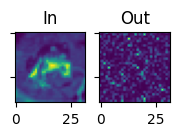

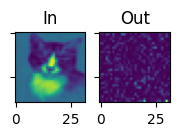

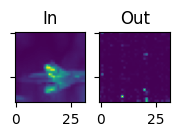

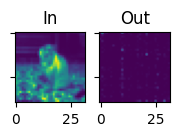

In [20]:
# Test
test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(fm)
ansatz_qc = ansatz(num_latent + num_trash)
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()
test_qc.reset(4)
test_qc.reset(3)
test_qc.barrier()
test_qc = test_qc.compose(ansatz_qc.inverse())

# sample new images
test_images, test_labels = get_dataset_cifar(2, draw=False)
for image, label in zip(test_images, test_labels):
    original_qc = fm.assign_parameters(image)
    original_sv = Statevector(original_qc).data
#     original_sv = np.reshape(np.abs(original_sv) ** 2, (8, 8))
    original_sv = np.reshape(np.abs(original_sv) ** 2, (32, 32))


    param_values = np.concatenate((image, opt_result.x))
    output_qc = test_qc.assign_parameters(param_values)
    output_sv = Statevector(output_qc).data
    output_sv = np.reshape(np.abs(output_sv) ** 2, (32,32))

    plt.rcParams["figure.figsize"] = (2, 1)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_yticklabels([])
    ax2.set_yticklabels([])
        
    ax1.imshow(original_sv)
    ax1.set_title("In")
    ax2.imshow(output_sv)
    ax2.set_title("Out")
    plt.show()

In [1]:
HTML("""
<style>
html{filter:invert(1)}

div.prompt{opacity: 0.5;}

.btn-default{border-color: transparent;}

#header-container{display:none !important;}

div.cell.selected, div.cell.selected.jupyter-soft-selected{border-color: transparent;}
</style>
""")